# Network Modifications - Roadways

In this notebook a copy of our baseline NetworkDataset is made to be modified reflecting the candidate improvement for roadway projects.

To use this notebook, modify the scenario name (below--no spaces or special characters) and run the three cells below, then run the approiate cell or cells under the "make edits" section corresponding to the project scope of work. Finally, run the cells at the bottom to save your work.

In [ ]:
scenario_name = "widen_12800_south"

In [ ]:
import sys
import os
import arcpy
import shutil

base_path = os.path.abspath(".")

src = os.path.join(base_path, 'src')
if src not in sys.path:
    sys.path.append(src)
    
from ato_tools import network
from ato_tools import scoring

target_gdb =  os.path.join(base_path, "scenario", "Driving", scenario_name + ".gdb")

In [ ]:
# create scenario file geodatabase from template

# if target gdb exists, delete it
if os.path.isdir(target_gdb):
    shutil.rmtree(target_gdb)
    
# copy template
shutil.copytree(r"scenario\scenario_template.gdb", target_gdb)

arcpy.env.workspace = target_gdb

# Add BikePedAuto layer to map for editing
arcpy.management.MakeFeatureLayer(
    os.path.join(target_gdb, r"NetworkDataset\BikePedAuto"), 
    "BPA"
)

# Make Edits

**Follow the instructions below for the appropriate section to make edits**


Project Type | Action 
---- | ----
New construction (line) | Add new line to network and make appropriate connections 
Widening (line) | Reduce travel time along links to free flow speed (Julie will ask Suzy what the travel time benefit is in the model) 
Operational (line) | Reduce travel time along links to average of free flow speed and peak hour speed 
Restripe (when is basically widening) (line) | Reduce travel time along links to free flow speed 
New interchange (point)  | Add connections in network 
Grade-separated crossing | Add new line across intersection (no intersection impedance) 



## New construction (line)

For new construction, new lines and connections are added to the BPA (BikePedAuto) layer in the Network Dataset.

**Instructions:** New features may be copied from another feature layer (e.g. a shapefile of candidate projects) or hand drawn into the `BPA` layer directly.

To copy an existing feature into the `BPA` layer:

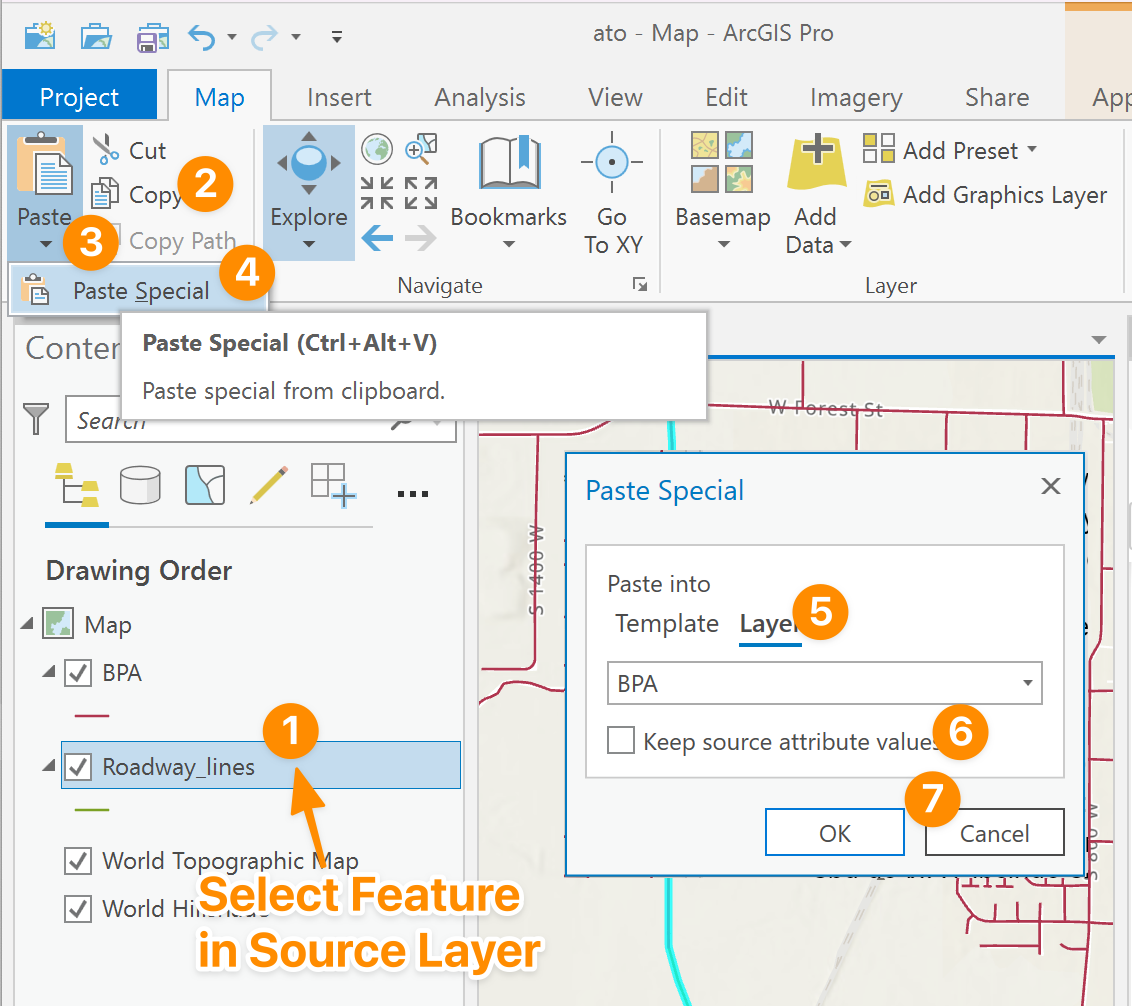

Open the Edit menu bar.

1. Copy existing line from source layer: (Edit --> Copy --> Paste Special). Paste into BikePedAuto layer and do NOT include attributes. Alternatively use the "Create Feature" tool to create a new feature by hand.
2. Edit vertices and ensure that beginning / end points connect to other beginning / end points. 
3. Use the **Transfer Attributes tool** to copy attributes from a similar nearby segment. Update the attributes as necessary (e.g. update the speed limit if appropriate). 

Note, when editing lines, take care to use snapping--overlapping verticies need to precisely connect.

Connecting the end point of a new line to the mid-point of an existing segment requires that the existing segment must be split at the connection point.

4. Select the intersecting road segments and use the Planarize Tool to split the intersecting lines (requires ArcGIS Pro Standard or Advanced). (With a ArcGIS Pro Standard License, use the Split tool at each intersection.)
5. Select all affected features and update length and speed attributes using cells below

In [ ]:
# UPDATE LENGTHS FOR SELECTED FEATURES - SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE
# this will likely throw some TypeErrors if the selectio includes non-roadway segments - ignore these!
if int(arcpy.management.GetCount("BPA")[0]) < 250:
    arcpy.management.CalculateField("BPA", "Length_Miles", '!shape.length@miles!', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "DriveTime", '!Length_Miles! / (!Speed! / 60)', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "PedestrianTime", '!Length_Miles! / (3 / 60)', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("BPA", "BikeTime", '!Length_Miles! / (11 / 60)', "PYTHON3", None, "DOUBLE")
else:
    print("Error: operation will affect more than 250 features. Did you select only the intended target?")

Now, save your edits and clear selection.

## Widening / Restripe (line)

For capacity expansion projects or restriping projects that add a lane, the DriveTime attribute is reduced from the Peak Hour speed to the Free Flow speed (or by 15% when travel demand model travel times are not available).

**Instructions:** Select segments to be modified then run the cell below and the "Save Edits" cells at the bottom of this notebook.

In [ ]:
# UPDATE LENGTHS FOR SELECTED FEATURES - SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE
# this will likely throw some TypeErrors if the selectio includes non-roadway segments - ignore these!
if int(arcpy.management.GetCount("BPA")[0]) < 200:
    arcpy.management.CalculateField(
        "BPA", "PK_SPD", '!FF_SPD!', "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "DriveTime_Peak", 
        '!Length_Miles! / (!FF_SPD! / 60)', "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "DriveTime", 
        '!DriveTime_Peak! if !DriveTime_Peak! else DriveTime * 0.85', 
        "PYTHON3", None, "DOUBLE"
    )
else:
    print("Warning: operation will affect more than 200 features - did you select only the intended target?")

## Operational (line)

Operational improvements are assumed to improve user operating speeds during the peak hour, but less so than a capacity expansion project. Reduce travel time along links to average of free flow speed and peak hour speed (or by 10% when travel demand model travel times are not available).

**Instructions:** Select segments to be modified then run the cell below and the "Save Edits" cells at the bottom of this notebook.

In [ ]:
# UPDATE LENGTHS FOR SELECTED FEATURES - SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE
# this will likely throw some TypeErrors if the selectio includes non-roadway segments - ignore these!
expression = '(!DriveTime_Peak! + !DriveTime_FF!) / 2 if !DriveTime_Peak! else !DriveTime! * 0.9'
if int(arcpy.management.GetCount("BPA")[0]) < 100:
    arcpy.management.CalculateField("BPA", "DriveTime", expression, "PYTHON3", None, "DOUBLE")
else:
    print("Warning: operation will affect more than 100 features - did you select only the intended target?")

## New interchange (point) 

Add connections in network.

**Instructions:** Select intrsecting segments and run **Planarize** tool.

## Grade-separated crossing

**Instructions** Dissolve the segments of each road or path such that the segments no longer break at the intersection. Add additional connector features as needed, Then run the cell below to update the travel time values.

In [ ]:
# UPDATE LENGTHS FOR SELECTED FEATURES - SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE
# this will likely throw some TypeErrors if the selectio includes non-roadway segments - ignore these!
if int(arcpy.management.GetCount("BPA")[0]) < 100:
    arcpy.management.CalculateField(
        "BPA", "Length_Miles", '!shape.length@miles!', 
        "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "DriveTime", '!Length_Miles! / (!Speed! / 60)', 
        "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "PedestrianTime", '!Length_Miles! / (3 / 60)', 
        "PYTHON3", None, "DOUBLE"
    )
    arcpy.management.CalculateField(
        "BPA", "BikeTime", '!Length_Miles! / (11 / 60)', 
        "PYTHON3", None, "DOUBLE"
    )
else:
    print("Warning: operation will affect more than 100 "
          "features - did you select only the intended target?")

# Save Edits

**Don't forget to save your edits!**

Save edits to BikePedAuto layer and remove from map. Then run the cells below to create the network dataset and build it.

In [ ]:
# save edits (if any) to BPA layer using the Edit ribbon - first!

# clear the selection before creating the new network dataset
arcpy.management.SelectLayerByAttribute("BPA", "CLEAR_SELECTION")

# remove layer from map
aprx = arcpy.mp.ArcGISProject("CURRENT")
mp = aprx.listMaps("Map")[0]
for layer in mp.listLayers():
    if layer.name == "BPA":
        mp.removeLayer(layer)

In [ ]:
nd = os.path.join(target_gdb, r"NetworkDataset\NetworkDataset_ND")
if arcpy.Exists(nd):
    arcpy.management.Delete(nd)
    
# create network dataset from template
arcpy.nax.CreateNetworkDatasetFromTemplate(
    os.path.join(base_path, "template.xml"),                 
    os.path.join(target_gdb, "NetworkDataset")
)

# finally, build the dataset
arcpy.nax.BuildNetwork(nd)

In [ ]:
# test network - if test fails, re-run cell above to re-create network dataset
test = network.test(nd)